BƯỚC 2: CHUẨN HÓA FEATURES VÀ TRÍCH XUẤT DISTRIBUTIONS

📂 2.1: Load user_features_step1.csv từ Bước 1...
✅ Loaded 1110 users với 10 features

Columns: ['userid', 'total_events', 'first_event', 'last_event', 'event_diversity', 'num_courses', 'active_days', 'avg_grade', 'grade_std', 'num_assessments']

First 5 rows:
   userid  total_events  first_event  last_event  event_diversity  \
0       3         14791   1662362711  1674590226               69   
1       4          8399   1662038222  1674557248               78   
2     203         11870   1662454980  1674053165               66   
3     231          5814   1662374274  1674569682               63   
4     702           848   1662086388  1674484921               21   

   num_courses  active_days  avg_grade  grade_std  num_assessments  
0           29          141  -0.666667    0.57735                3  
1           18          144   0.000000    0.00000                2  
2           18          134  -1.000000    0.00000             

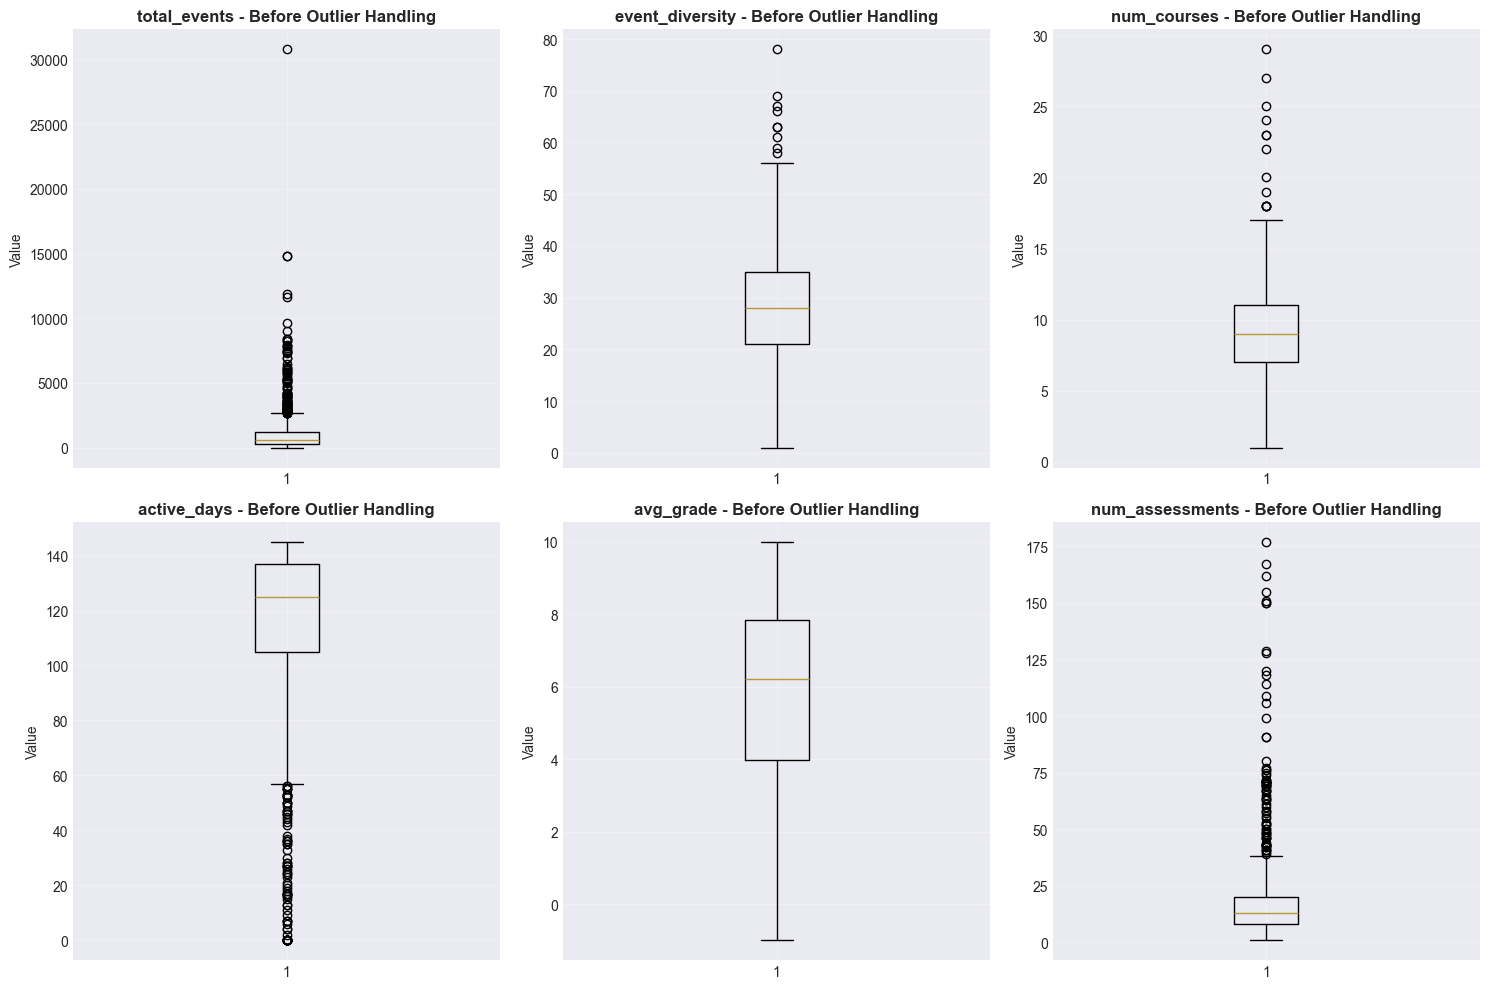

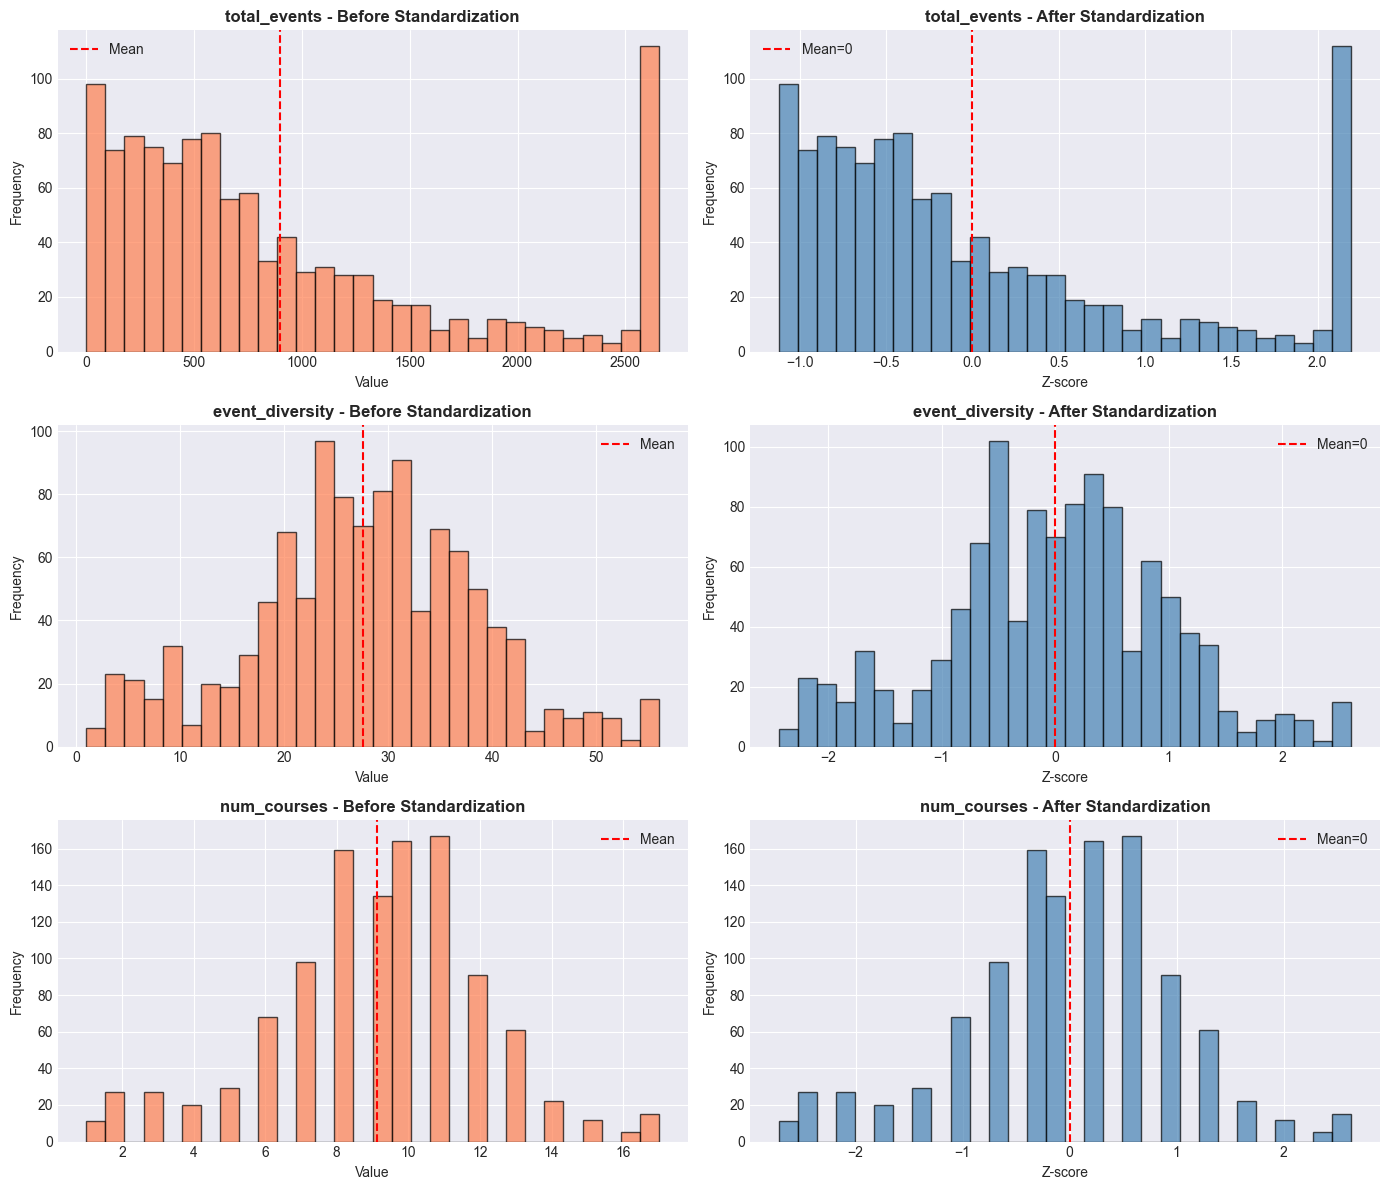

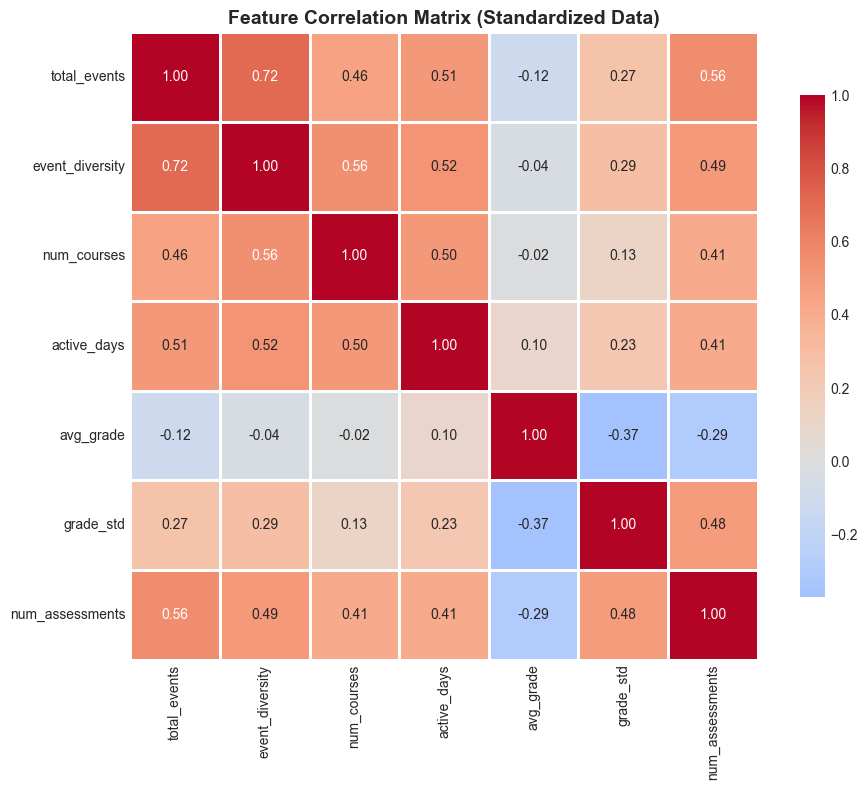

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
import json
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# BƯỚC 2: FEATURE STANDARDIZATION & STATISTICAL DISTRIBUTION EXTRACTION
# ============================================================================

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("BƯỚC 2: CHUẨN HÓA FEATURES VÀ TRÍCH XUẤT DISTRIBUTIONS")
print("="*80)

# ----------------------------------------------------------------------------
# 2.1: LOAD DỮ LIỆU TỪ BƯỚC 1
# ----------------------------------------------------------------------------
print("\n📂 2.1: Load user_features_step1.csv từ Bước 1...")

# Load file đã tạo từ Bước 1
df = pd.read_csv('../step1_eda/user_features_step1.csv')

print(f"✅ Loaded {len(df)} users với {len(df.columns)} features")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:\n{df.head()}")

# ----------------------------------------------------------------------------
# 2.2: DATA CLEANING & MISSING VALUE HANDLING
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.2: XỬ LÝ MISSING VALUES VÀ DATA CLEANING")
print("="*80)

print(f"\n📊 Missing values trước khi xử lý:")
print(df.isnull().sum())

# Fill missing values với median (robust với outliers)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"   • Filled {col} missing values với median = {median_val:.2f}")

# Xử lý grade_std = NaN (users có 1 assessment duy nhất → std = 0)
if 'grade_std' in df.columns:
    df['grade_std'].fillna(0, inplace=True)
    print(f"   • Filled grade_std NaN với 0 (students có 1 assessment)")

print(f"\n✅ Missing values sau khi xử lý:")
print(df.isnull().sum())

# ----------------------------------------------------------------------------
# 2.3: OUTLIER DETECTION & HANDLING
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.3: PHÁT HIỆN VÀ XỬ LÝ OUTLIERS")
print("="*80)

def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Phân tích outliers cho mỗi feature
outlier_summary = {}
features_to_check = ['total_events', 'event_diversity', 'num_courses', 
                     'active_days', 'avg_grade', 'num_assessments']

for col in features_to_check:
    if col in df.columns:
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_summary[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(df) * 100,
            'lower_bound': float(lower),
            'upper_bound': float(upper)
        }
        print(f"\n🔍 {col}:")
        print(f"   • Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
        print(f"   • Bounds: [{lower:.2f}, {upper:.2f}]")

# Visualization: Boxplots trước khi xử lý outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(features_to_check):
    if col in df.columns:
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'{col} - Before Outlier Handling', fontweight='bold')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('step2_outliers_before.png', dpi=150, bbox_inches='tight')
print("\n✅ Saved: step2_outliers_before.png")

# Xử lý outliers: Capping (Winsorization) thay vì remove
# Tại sao? Vì ta cần giữ lại số lượng users cho clustering
df_cleaned = df.copy()

for col in features_to_check:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers
        df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

print(f"\n✅ Đã xử lý outliers bằng Winsorization (capping)")

# ----------------------------------------------------------------------------
# 2.4: FEATURE STANDARDIZATION (Z-SCORE NORMALIZATION)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.4: CHUẨN HÓA FEATURES (Z-SCORE NORMALIZATION)")
print("="*80)

# Chọn features để standardize (exclude userid)
features_to_scale = [col for col in df_cleaned.columns if col not in ['userid', 'first_event', 'last_event']]

print(f"\n📋 Features sẽ được chuẩn hóa: {features_to_scale}")

# Method 1: StandardScaler (Z-score: (x - mean) / std)
scaler_standard = StandardScaler()
df_standardized = df_cleaned.copy()
df_standardized[features_to_scale] = scaler_standard.fit_transform(df_cleaned[features_to_scale])

print(f"\n✅ Áp dụng StandardScaler (Z-score normalization)")
print(f"\nKiểm tra sau khi standardize (should have mean≈0, std≈1):")
print(df_standardized[features_to_scale].describe())

# Method 2: RobustScaler (dùng median và IQR - robust hơn với outliers)
# Uncomment nếu muốn dùng RobustScaler thay vì StandardScaler
# scaler_robust = RobustScaler()
# df_robust = df_cleaned.copy()
# df_robust[features_to_scale] = scaler_robust.fit_transform(df_cleaned[features_to_scale])

# Save scaler để dùng cho dữ liệu mới (important cho production)
import pickle
with open('scaler_step2.pkl', 'wb') as f:
    pickle.dump(scaler_standard, f)
print(f"\n✅ Saved scaler: scaler_step2.pkl (dùng để transform new data)")

# ----------------------------------------------------------------------------
# 2.5: STATISTICAL DISTRIBUTION EXTRACTION (CHI TIẾT)
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.5: TRÍCH XUẤT STATISTICAL DISTRIBUTIONS (CHI TIẾT)")
print("="*80)

def extract_distribution_stats(data, column):
    """Extract comprehensive statistical properties"""
    values = data[column].dropna()
    return {
        'mean': float(values.mean()),
        'median': float(values.median()),
        'std': float(values.std()),
        'variance': float(values.var()),
        'min': float(values.min()),
        'max': float(values.max()),
        'range': float(values.max() - values.min()),
        'q1': float(values.quantile(0.25)),
        'q3': float(values.quantile(0.75)),
        'iqr': float(values.quantile(0.75) - values.quantile(0.25)),
        'skewness': float(stats.skew(values)),
        'kurtosis': float(stats.kurtosis(values)),
        'count': int(len(values))
    }

# Extract distributions CHO CẢ DỮ LIỆU GỐC VÀ STANDARDIZED
distributions_original = {}
distributions_standardized = {}

for col in features_to_scale:
    distributions_original[col] = extract_distribution_stats(df_cleaned, col)
    distributions_standardized[col] = extract_distribution_stats(df_standardized, col)
    
    print(f"\n📊 {col} - Original vs Standardized:")
    print(f"   • Original:     mean={distributions_original[col]['mean']:.2f}, std={distributions_original[col]['std']:.2f}, skew={distributions_original[col]['skewness']:.2f}")
    print(f"   • Standardized: mean={distributions_standardized[col]['mean']:.2f}, std={distributions_standardized[col]['std']:.2f}, skew={distributions_standardized[col]['skewness']:.2f}")

# Save distributions
output_distributions = {
    'original': distributions_original,
    'standardized': distributions_standardized,
    'outlier_summary': outlier_summary,
    'scaler_params': {
        'mean': scaler_standard.mean_.tolist(),
        'std': scaler_standard.scale_.tolist(),
        'features': features_to_scale
    }
}

with open('distributions_step2.json', 'w') as f:
    json.dump(output_distributions, f, indent=2)
print(f"\n✅ Saved: distributions_step2.json")

# ----------------------------------------------------------------------------
# 2.6: VISUALIZATION - BEFORE vs AFTER STANDARDIZATION
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.6: VISUALIZATION - BEFORE vs AFTER")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for idx, col in enumerate(features_to_scale[:3]):  # Plot first 3 features
    # Before standardization
    axes[idx, 0].hist(df_cleaned[col], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'{col} - Before Standardization', fontweight='bold')
    axes[idx, 0].set_xlabel('Value')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].axvline(df_cleaned[col].mean(), color='red', linestyle='--', label='Mean')
    axes[idx, 0].legend()
    
    # After standardization
    axes[idx, 1].hist(df_standardized[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx, 1].set_title(f'{col} - After Standardization', fontweight='bold')
    axes[idx, 1].set_xlabel('Z-score')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].axvline(0, color='red', linestyle='--', label='Mean=0')
    axes[idx, 1].legend()

plt.tight_layout()
plt.savefig('step2_standardization_comparison.png', dpi=150, bbox_inches='tight')
print("✅ Saved: step2_standardization_comparison.png")

# ----------------------------------------------------------------------------
# 2.7: CORRELATION ANALYSIS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.7: CORRELATION ANALYSIS")
print("="*80)

# Correlation matrix (dùng data standardized)
corr_matrix = df_standardized[features_to_scale].corr()

print("\n📊 Correlation Matrix:")
print(corr_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Standardized Data)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('step2_correlation_matrix.png', dpi=150, bbox_inches='tight')
print("✅ Saved: step2_correlation_matrix.png")

# Phát hiện highly correlated features (|correlation| > 0.8)
print("\n🔍 Highly correlated feature pairs (|r| > 0.8):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(pair)
            print(f"   • {pair[0]} <-> {pair[1]}: r = {pair[2]:.3f}")

if not high_corr_pairs:
    print("   • Không có feature pairs với correlation > 0.8")

# ----------------------------------------------------------------------------
# 2.8: SAVE OUTPUT CHO BƯỚC 3
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("2.8: SAVE OUTPUT CHO BƯỚC 3 (CLUSTERING)")
print("="*80)

# Save cleaned and standardized data
df_cleaned.to_csv('user_features_cleaned.csv', index=False)
df_standardized.to_csv('user_features_standardized.csv', index=False)

print(f"✅ Saved: user_features_cleaned.csv (data sau khi clean outliers)")
print(f"✅ Saved: user_features_standardized.csv (data đã standardize - dùng cho Bước 3)")

# ----------------------------------------------------------------------------
# 2.9: KẾT LUẬN VÀ NEXT STEPS
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("🎯 BƯỚC 2 HOÀN THÀNH - KẾT LUẬN")
print("="*80)

print(f"""
✅ ĐÃ HOÀN THÀNH:
   1. ✓ Xử lý missing values
   2. ✓ Detect và handle outliers (Winsorization)
   3. ✓ Standardize features (Z-score normalization)
   4. ✓ Trích xuất statistical distributions chi tiết
   5. ✓ Phân tích correlation giữa các features
   
📂 OUTPUT FILES:
   • user_features_cleaned.csv - Data sau khi clean (cho backup)
   • user_features_standardized.csv - Data đã standardize (DÙNG CHO BƯỚC 3)
   • distributions_step2.json - Statistical distributions
   • scaler_step2.pkl - Scaler object (cho production)
   • step2_outliers_before.png - Visualization outliers
   • step2_standardization_comparison.png - Before/After comparison
   • step2_correlation_matrix.png - Correlation heatmap

📊 DATA SUMMARY:
   • Total users: {len(df_standardized)}
   • Features standardized: {len(features_to_scale)}
   • Outliers handled: {sum([v['count'] for v in outlier_summary.values()])} records capped
   • Highly correlated pairs: {len(high_corr_pairs)}

🔜 NEXT STEPS (BƯỚC 3 - CLUSTERING):
   → Dùng file: user_features_standardized.csv
   → Apply K-Means, DBSCAN, hoặc Hierarchical Clustering
   → Xác định optimal number of clusters (Elbow method, Silhouette score)
   → Tạo student archetypes: "fast learner", "slow repeater", "hint seeker"...

💡 LIÊN KẾT VỚI Q-LEARNING:
   • Standardized features → STATE SPACE design
     Ví dụ state: (engagement_level, performance_level, knowledge_level)
   • Correlation analysis → giúp chọn features không redundant cho state
   • Distributions → dùng cho Bước 5 (sinh synthetic data realistic)
   • Student archetypes (Bước 3) → có thể dùng như discrete states trong Q-table
""")

plt.show()